<h1><center>Principal Component Analysis (PCA) </center></h1>

## ¿Qué es?
En _términos generales_: Es un procedimiento _estadístico_ para transformar un conjunto de datos que pueden estar **correlacionados** a un conjunto de datos nuevo que **no** están **correlacionados _linealmente_.** La propiedad _estadística_ que se debe preservar es la **varianza** de estos nuevos datos, llamados **componentes principales**; de esta forma se seleccionan los _componentes principales_ que se deseen y se garantiza que dado que sus varianzas son grandes, estos componentes forman una nueva _base ortogonal_ en la cual están los datos originales.

## ¿Cómo se implementa?
Existen **dos** metodologías _básicas_ (esta técnica tiene implementaciones más generales, para más información ver [este documento](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf) ):
1. **Eigenvectores de la matriz de covarianza:** La _matriz de covarianza_ tiene en sus entradas fuera de la diagonal principal los valores de la _covarianza_ entre las variables; el método de _PCA_ exige que la covarianza sea _nula_ (que no haya correlación entre las variables), por lo que se busca que la matriz de covarianza tenga entradas _nulas_, en otras palabras, que se **diagonalice**. Para realizar esto, se pretende encontrar la **eigendescomposición** de la matriz de covarianza para _diagonalizarla_, luego utilizar esta nueva matriz para transformar los datos y efectivamente encontrar los _componentes principales._ (También ver [esta página](http://mathworld.wolfram.com/EigenDecomposition.html))

2. **Por descomposición de valores singulares (SVD):** ¿Qué pasa cuando la matriz de covarianza **no** puede ser diagonalizada por su _eigendescomposición_? (El porqué y cuándo sucede esto se deja al lector; [aquí](http://mathworld.wolfram.com/SingularValueDecomposition.html) y [aquí](https://en.wikipedia.org/wiki/Singular_value_decomposition) hay más información) Cuando esto sucede queda una opción muy _poderosa_, _robusta_ y _matemáticamente rigurosa_: la _descomposición de valores singulares_. La idea general de esta descomposición es que se tenga una nueva base ortogonal utilizando _la raíz cuadrada_ de los _eigenvalores_ de la matriz.

### Pseudo-algoritmo (para SVD y _reducción de dimensionalidad_):
1. Tomar los datos y organizarlos en una matriz $m \times n$ donde $m$ el _número de características_ y $n$ es el número de _muestras._

2. Restar la _media_ de cada _clase_ a los datos.

3. Realizar la _descomposición_ SVD y tomar sólo los $k$ componentes que se deseen; con estos nuevos datos se realiza una _reducción de dimensión._

4. Utilizar cualquier modelo de predicción o clasificación con estos datos.

## Conceptos útiles

1. **Base ortogonal:** Un conjunto de vectores que generan un espacio vectorial; todo vector (en el sentido más general) puede ser reescrito como una combinación lineal de esta base. (Para más información ver [esta página](http://mathworld.wolfram.com/VectorBasis.html))

2. **Single Value Decomposition (SVD):** Sea una matriz $\mathbf{M}$ de tamaño $m \times n$ con $m > n$, entonces su _descomposición_ SVD es $$\mathbf{M} = \mathbf{U} \mathbf{D} \mathbf{V}^{T} ,$$ donde $\mathbf{U}$ es una matriz _unitaria_, $\mathbf{D}$ es una matriz _diagonal_ que contiene sus _valores singualares_ y $\mathbf{V}$ también es una matriz _unitaria._ Es muy importante notar que las columnas de las matrices $\mathbf{U}$ y $\mathbf{V}$ son ortogonales entre sí y forman una _base._ ([Más información]( http://mathworld.wolfram.com/UnitaryMatrix.html) sobre matrices unitarias.)

3. **Eigendescomposición:** Sea una matriz _cuadrada_ $\mathbf{M}$, entonces su _eigendescomposición_ está dada por $$\mathbf{M} = \mathbf{P} \mathbf{D} \mathbf{P}^{-1} ,$$ donde $\mathbf{P}$ es una matriz cuadrada que contiene los _eigenvectores_ de la matriz $\mathbf{M}$, mientras que $\mathbf{D}$ es una matriz _diagonal_ que contiene los _eigenvalores_ de la matriz $\mathbf{M}.$

4. **Transformación ortogonal:** Una _transformación ortogonal_ es una transformación lineal $T: V \rightarrow V$ que preserva el _producto interno_ tal que $\langle u, v \rangle = \langle Tu, Tv \rangle .$ (Ver [esta página](https://en.wikipedia.org/wiki/Orthogonal_transformation))

In [33]:
# Importar las librerías usuales
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # Para el estilo de las gráficas
import numpy as np
%matplotlib inline

# Ajustar tamaño y formato de las figuras
mpl.rcParams['figure.figsize'] = (21, 10)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 16

## Ejemplo ilustrativo (cualitativo) de PCA

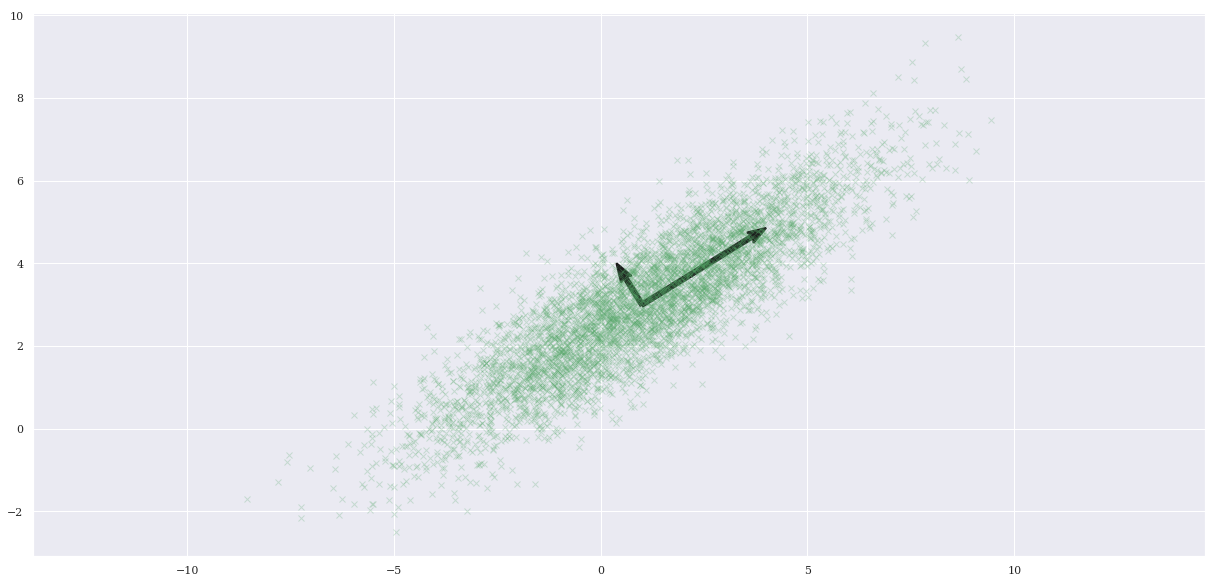

In [34]:
# Crear datos de una distribución Gaussiana 2D
mean = np.array([1, 3])
cov = np.array([[7, 4], [4, 3]])
x, y = np.random.multivariate_normal(mean, cov, size=5000).T

# Eigenvectores y eigenvalores de la matriz de covarianza
eigv, eigvl = np.linalg.eig(cov)

# Graficar el conjunto de datos
plt.plot(x, y, 'x', alpha=0.25, color='g')
# Y los eigenvectores centrados en la media, escalados por la raíz cuadrada de sus eigenvalores
plt.arrow(*mean, *eigvl[:, 0]*np.sqrt(eigv[0]), width=0.1, color="k", lw=2,
          overhang=0.1)
plt.arrow(*mean, *eigvl[:, 1]*np.sqrt(eigv[1]), width=0.1, color="k", lw=2,
          overhang=0.1)
plt.grid(True)
plt.axis('equal')
plt.show()

## _Primera parte_: Implementación de PCA, pruebas iniciales.

In [3]:
# Implementación propia para ajustar los datos a mis propias implementaciones
def data_proc(x, y, n_caract, n_clas):
    arreglados = sorted(zip(y, x), key=lambda pair: pair[0])
    dicc_datos = dict()
    for i in range(n_clas):
        dicc_datos[i] = np.array([])

    for l, k in dicc_datos.items():
        lista_vals = list()
        for m in range(n_caract):
            list_arr_1 = np.array([])
            for i, j in arreglados:
                if i == l:
                    list_arr_1 = np.append(list_arr_1, j[m])
            lista_vals.append(list_arr_1)

            dicc_datos[l] = np.stack(lista_vals, axis=0)
            
    return dicc_datos

In [4]:
def flip_signs(u, v):
    # Tomado de https://github.com/scikit-learn/scikit-learn/blob/62d205980446a1abc1065f4332fd74eee57fcf73/sklearn/utils/extmath.py
    max_abs_rows = np.argmax(np.abs(v), axis=1)
    signs = np.sign(v[range(v.shape[0]), max_abs_rows])
    u *= signs
    v *= signs[:, np.newaxis]
    return u, v

def pca_svd(entre, data, n_comp):
    # Centrar los datos en la media
    data -= entre.mean(axis=0)
    # Realizar la descomposición SVD
    u, d, vh = np.linalg.svd(data, full_matrices=False)
    # Cambiar los signos entre U y V
    u, vh = flip_signs(u, vh)
    # Realizar el producto matricial
    mat_prod = u @ np.diag(d)
    
    # Regresar los n_comp número de componentes necesarios
    return mat_prod[:, :n_comp]

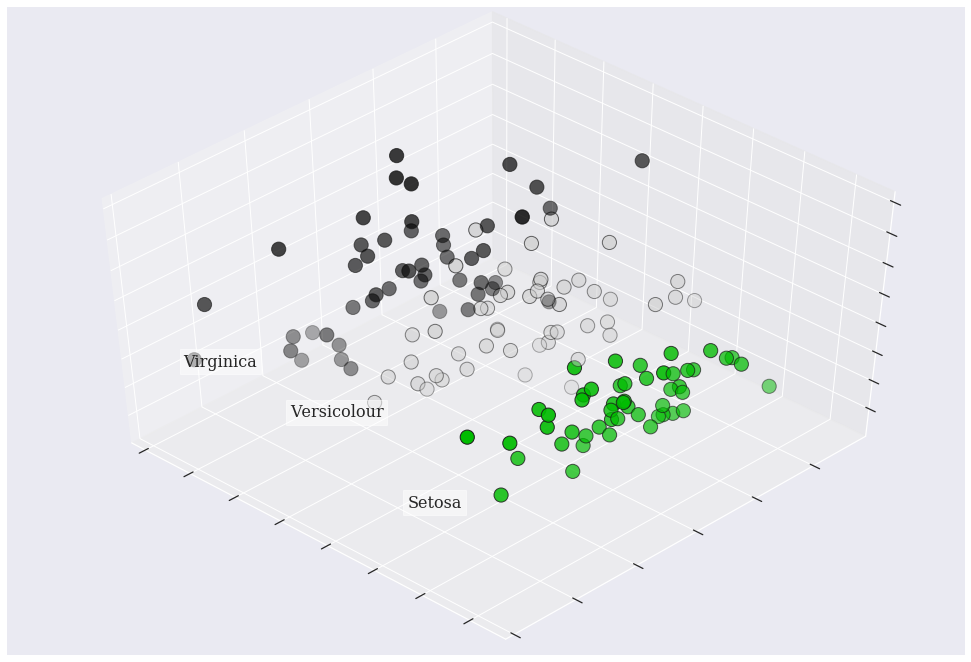

In [35]:
# Tomado de https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py
# y modificado para esta libreta
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

centers = [[1, 1], [-1, -1], [1, -1]]
iris = datasets.load_iris()
X = iris.data
y = iris.target

fig = plt.figure(1, figsize=(14, 9))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()

# Usar PCA y transformar
iris_pca = pca_svd(X, X, 3)

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(iris_pca[y == label, 0].mean(),
              iris_pca[y == label, 1].mean() + 1.5,
              iris_pca[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reacomodar las etiquetas para que la gráfica muestre las clases correctamente
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(iris_pca[:, 0], iris_pca[:, 1], iris_pca[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k', s=200)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

## _Segunda parte._ Clasificación de dígitos.

### _Naive Bayes_

In [6]:
def gaussian_nb(entrena, pred):
    h_disc = dict()
    total_puntos = sum([i.shape[1] for i in entrena.values()])
    
    # Una constante útil
    log_2pi = np.log(2.0 * np.pi)
    
    for i, j in entrena.items():
        # Calcular la distancia a la media
        delta = pred - np.mean(j, axis=1)
        # Encontrar la matriz de covarianza
        matr_cov = np.cov(j)
        # Y su inversa
        inv_cov_matr = np.linalg.pinv(matr_cov)
        # Distancia de Mahalanobis
        m_dist = -0.5 * np.dot(np.dot(delta, inv_cov_matr), delta)
        # Restar el siguiente término, depende de la dimensión del arreglo
        m_dist += -0.5 * j.shape[0] * log_2pi
        # Calcular el determinante de la matriz de covarianza, restarlo
        # de la distancia acumulada
        eig_values = np.linalg.eigvals(matr_cov)
        pseudo_det = np.product(eig_values[eig_values > 0])
        m_dist += -0.5 * np.log(pseudo_det)
        # Calcular la probabilidad a priori, y sumarla a la distancia
        a_priori = j.shape[1] / total_puntos
        m_dist += np.log(a_priori)
        # Agregar esta probabilidad al diccionario final
        h_disc[i] = m_dist
        
    # Devolver aquella clase que contiene la mayor probabilidad
    return max(h_disc, key=h_disc.get)

In [7]:
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.metrics import accuracy_score

# Base de datos de dígitos
digits, etiq = datasets.load_digits(return_X_y=True)

# Separar los datos en diferentes 10 conjuntos de datos
skf_dig = model_selection.StratifiedKFold(n_splits=10)

# Crear un arreglo para guardar los porcentajes
mean_score = np.array([])

# Realizar validación cruzada del clasificador
for train_index, test_index in skf_dig.split(digits, etiq):
    # Crear los conjuntos de datos
    x_entre, x_prueba = digits[train_index], digits[test_index]
    y_entre, y_prueba = etiq[train_index], etiq[test_index]
    
    # Diccionario de entrenamiento
    dicc_entre = data_proc(x_entre, y_entre, 64, 10)
    
    # Crear la lista de clasificación
    lista_digitos = np.array([])
    for i in x_prueba:
        lista_digitos = np.append(lista_digitos, gaussian_nb(dicc_entre, i))
    
    # Calcular el porcentaje de clasificaciones correctas
    mean_score = np.append(mean_score, accuracy_score(y_prueba, lista_digitos))
    
print(f'Predicción media del clasificador Gaussiano: {mean_score.mean()}')

Predicción media del clasificador Gaussiano: 0.9348926290907444


In [8]:
x_entre, x_prueba, y_entre, y_prueba = model_selection.train_test_split(digits, etiq, test_size=0.3)
# Diccionario de entrenamiento
dicc_entre = data_proc(x_entre, y_entre, 64, 10)

# Crear la lista de clasificación
lista_digitos = np.array([])
for i in x_prueba:
    lista_digitos = np.append(lista_digitos, gaussian_nb(dicc_entre, i))
    
print('Reporte de clasificación para el clasificador Gaussiano:')
print(classification_report(y_prueba, lista_digitos))

Reporte de clasificación para el clasificador Gaussiano:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       1.00      0.89      0.94        63
           2       0.98      0.98      0.98        53
           3       0.96      0.92      0.94        52
           4       0.95      0.93      0.94        44
           5       0.97      0.98      0.97        59
           6       1.00      0.98      0.99        63
           7       0.94      0.98      0.96        46
           8       0.89      0.98      0.93        51
           9       0.92      0.95      0.93        58

   micro avg       0.96      0.96      0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



### _k-Nearest Neighbors_

In [9]:
from scipy.spatial import cKDTree

class k_nearest_n:
    def __init__(self, k_n):
        self.kd_tree = None
        self.prob_dicc = dict()
        self.kn = k_n
        self.labels = None
        
    def fit(self, entrena, etiq):
        self.kd_tree = cKDTree(entrena)
        self.labels = etiq
        for i in range(len(np.unique(self.labels))):
            self.prob_dicc[i] = 0.0
    
    def predecir(self, pred):
        __, indices = self.kd_tree.query(pred, k=self.kn)
    
        for k in self.prob_dicc.keys():
            prob = 0.0
            for i, j in enumerate(self.labels):
                for l in indices:
                    if i == l:
                        if j == k:
                            self.prob_dicc[k] += 1

        for i, j in self.prob_dicc.items():
            self.prob_dicc[i] = j / self.kn

    #     print(prob_dicc)
        return max(self.prob_dicc, key=self.prob_dicc.get)

In [10]:
from sklearn.decomposition import PCA

k_vals = [3, 5, 7, 9]

for j in k_vals:
    # Crear un arreglo para guardar los porcentajes
    mean_score = np.array([])
    
    # Realizar validación cruzada del clasificador
    for train_index, test_index in skf_dig.split(digits, etiq):
        # Crear los conjuntos de datos
        x_entre, x_prueba = digits[train_index], digits[test_index]
        y_entre, y_prueba = etiq[train_index], etiq[test_index]
        
        pca = PCA(n_components=50)
        pca.fit(x_entre)
        x_entre_pca = pca.transform(x_entre)
        x_prueba_pca = pca.transform(x_prueba)

#         x_entre_pca = pca_svd(x_entre, x_entre, 50)
#         x_prueba_pca = pca_svd(x_entre, x_prueba, 50)

        # Crear el clasificador
        knn = k_nearest_n(j)
        knn.fit(x_entre_pca, y_entre)

        # Crear la lista de clasificación
        lista_digitos = np.array([])
        for i in x_prueba_pca:
            lista_digitos = np.append(lista_digitos, knn.predecir(i))

        # Calcular el porcentaje de clasificaciones correctas
        mean_score = np.append(mean_score, accuracy_score(y_prueba, lista_digitos))

    print(f'Predicción media del clasificador {j}-NN: {mean_score.mean()}')

Predicción media del clasificador 3-NN: 0.9772179270949165
Predicción media del clasificador 5-NN: 0.9744979352633549
Predicción media del clasificador 7-NN: 0.9695049695600133
Predicción media del clasificador 9-NN: 0.9667419684057993


In [11]:
x_entre, x_prueba, y_entre, y_prueba = model_selection.train_test_split(digits, etiq, test_size=0.3)
pca = PCA(n_components=50)
pca.fit(x_entre)
x_entre_pca = pca.transform(x_entre)
x_prueba_pca = pca.transform(x_prueba)

# Crear el clasificador
knn = k_nearest_n(3)
knn.fit(x_entre_pca, y_entre)

# Crear la lista de clasificación
lista_digitos = np.array([])
for i in x_prueba_pca:
    lista_digitos = np.append(lista_digitos, knn.predecir(i))
    
print('Reporte de clasificación para el clasificador 3-NN:')
print(classification_report(y_prueba, lista_digitos))

Reporte de clasificación para el clasificador 3-NN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       0.98      1.00      0.99        55
           2       1.00      1.00      1.00        47
           3       0.98      1.00      0.99        45
           4       1.00      1.00      1.00        57
           5       1.00      0.98      0.99        53
           6       0.98      1.00      0.99        46
           7       1.00      0.98      0.99        61
           8       0.98      0.96      0.97        54
           9       0.97      0.97      0.97        61

   micro avg       0.99      0.99      0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



## _Tercera parte._ Datos de muy alta dimensionalidad y uso de PCA (scikit-learn).

In [27]:
# Extraer todos los datos, completos
conjunto_datos = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

datos_gente = conjunto_datos.data
target_names = conjunto_datos.target_names
etiq_gente = conjunto_datos.target

x_entre, x_prueba, y_entre, y_prueba = model_selection.train_test_split(datos_gente, etiq_gente, test_size=0.25)

pca = PCA(n_components=150)
pca.fit(x_entre)
x_entre_pca = pca.transform(x_entre)
x_prueba_pca = pca.transform(x_prueba)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

k_vals = {'n_neighbors': [3, 5, 7, 9]}

knn_skl = model_selection.GridSearchCV(KNeighborsClassifier(weights='distance', n_jobs=2), param_grid=k_vals, cv=10, n_jobs=-2)

knn_skl.fit(x_entre_pca, y_entre)
print(knn_skl.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=2, n_neighbors=9, p=2,
           weights='distance')


/Users/edwin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [29]:
y_pred = knn_skl.predict(x_prueba_pca)

# print(target_names)
print(classification_report(y_prueba, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.57      0.27      0.36        15
     Colin Powell       0.58      0.69      0.63        54
  Donald Rumsfeld       0.73      0.25      0.37        32
    George W Bush       0.68      0.91      0.78       148
Gerhard Schroeder       0.67      0.06      0.11        32
      Hugo Chavez       0.50      0.20      0.29        10
       Tony Blair       0.45      0.48      0.47        31

        micro avg       0.63      0.63      0.63       322
        macro avg       0.60      0.41      0.43       322
     weighted avg       0.63      0.63      0.58       322



In [30]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

mean_score = model_selection.cross_val_score(gnb, x_entre_pca, y_entre, cv=10, n_jobs=-1)

print(mean_score.mean())

0.686228049905809


In [31]:
gnb.fit(x_entre_pca, y_entre)

y_pred = gnb.predict(x_prueba_pca)

print(classification_report(y_prueba, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.38      0.40      0.39        15
     Colin Powell       0.68      0.63      0.65        54
  Donald Rumsfeld       0.90      0.56      0.69        32
    George W Bush       0.72      0.89      0.80       148
Gerhard Schroeder       0.94      0.47      0.62        32
      Hugo Chavez       0.67      0.80      0.73        10
       Tony Blair       0.80      0.65      0.71        31

        micro avg       0.72      0.72      0.72       322
        macro avg       0.73      0.63      0.66       322
     weighted avg       0.74      0.72      0.72       322



## _Conclusiones_

1. **PCA** es un método que depende mucho de la forma de _implementación_, si la implementación es _clásica_ sólo algunos
   casos pueden ser estudiados (pocas clases, dimensiones intermedias).

2. Como se esperaba, el clasificador _bayesiano_ es mejor en datos con dimensión muy superior, el caso del conjunto de dato de los dígitos es interesante
   de estudiar por el hecho de que al reducir la dimensión,  kNN es mucho mejor.
   
3. Para conjuntos de datos con dimensiones muy superiores, incluso cuando están reducidos con PCA, se requiere de clasificadores mucho mejores (SVM o redes neuronales.)